In [1]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set(style="ticks")
sns.set_context("paper",
                rc={"lines.linewidth": 2.5,
                'xtick.labelsize':8,
                'ytick.labelsize':8,
                'lines.markersize' : 8,
                'legend.fontsize': 8,
                'axes.labelsize': 8,
                'legend.handlelength': 1,
                'legend.handleheight':1,})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Learning results

In [83]:
import os
import json
import pandas as pd

# Define the directory name
multitask = "split-c100-classes-10_resnet18_base_multihead_multitask-exp2-20250320_124048"
singletask = "split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024"
replay05 = "split-c100-classes-10_resnet18_replay_multihead_singletask-exp2-20250319_180051"
replay01 = "split-c100-classes-10_resnet18_replay_multihead_singletask-exp2-20250319_182618"
replay001 = "split-c100-classes-10_resnet18_replay_multihead_singletask-exp2-20250319_185604"
replayfixed = "split-c100-classes-10_resnet18_replay_multihead_singletask-exp2-20250319_193440"

exp_name = singletask
directory = f"experiments/{exp_name}/results"

# Load the JSON file
with open(os.path.join(directory, "experiments.json"), "r") as file:
    data = json.load(file)

# Extract the "config" dictionary and save it into a pandas dataframe
config_df = pd.DataFrame([data[0]["config"]])

# Add the "end_results" dictionary to the dataframe
end_results = data[0]["end_results"]
for key, value in end_results.items():
    config_df[key] = value

# Load the "transfer" dictionary
transfer_dict = data[0]["transfer"]

print(config_df)
print(transfer_dict)

    network optimizer    lr  weight_decay  momentum  step_scheduler_decay  \
0  resnet18       SGD  0.05       0.00001       0.9                   300   

   cosine_scheduler_duration  scheduler_step scheduler_type loss  ...  \
0                        1.0             0.1  cosine_anneal   CE  ...   

                 environment  agent_type num_classes_per_task  \
0  split-cifar100-classes-10        base                   10   

  num_classes_total multihead experiment_duration  device        date  \
0               100      True               10000       1  2025-03-19   

   test_loss_end test_error_end  
0        2.37591       0.535156  

[1 rows x 30 columns]
{'0': {'0': {'test_loss': 1.2472610473632812, 'test_error': 0.24843746423721313, 'task_name': 'split_classes_10_0'}, '1': {'test_loss': 2.334827184677124, 'test_error': 0.8828125, 'task_name': 'split_classes_10_1'}, '2': {'test_loss': 2.3774771690368652, 'test_error': 0.8937499970197678, 'task_name': 'split_classes_10_2'}, '3':

In [84]:
config_df.columns

Index(['network', 'optimizer', 'lr', 'weight_decay', 'momentum',
       'step_scheduler_decay', 'cosine_scheduler_duration', 'scheduler_step',
       'scheduler_type', 'loss', 'batch_size', 'warmup_on', 'exp_id',
       'exp_timestamp', 'exp_name', 'exp_type', 'seed', 'steps_per_task',
       'num_tasks', 'ordering', 'environment', 'agent_type',
       'num_classes_per_task', 'num_classes_total', 'multihead',
       'experiment_duration', 'device', 'date', 'test_loss_end',
       'test_error_end'],
      dtype='object')

In [85]:
import numpy as np

# Initialize the matrix
num_tasks = len(transfer_dict)
matrix = np.zeros((num_tasks, num_tasks))

# Populate the matrix
for i in range(num_tasks):
    for j in range(num_tasks):
        matrix[i, j] = transfer_dict[str(i)][str(j)]['test_error']

print(matrix)

[[0.24843746 0.8828125  0.89375    0.8890625  0.8953125  0.89375
  0.9171875  0.9015625  0.8671875  0.9171875 ]
 [0.56562498 0.30156249 0.8765625  0.9015625  0.8859375  0.8875
  0.9234375  0.85625    0.8703125  0.9203125 ]
 [0.63906249 0.58281249 0.2421875  0.89375    0.8875     0.8921875
  0.9015625  0.925      0.85312499 0.9171875 ]
 [0.68125001 0.58124998 0.46249998 0.26249999 0.8875     0.875
  0.846875   0.890625   0.859375   0.915625  ]
 [0.6875     0.57187501 0.5078125  0.48124999 0.22499996 0.88125
  0.8875     0.8765625  0.8765625  0.9359375 ]
 [0.753125   0.703125   0.64531249 0.60468748 0.453125   0.21562499
  0.890625   0.86093749 0.87343749 0.921875  ]
 [0.7734375  0.65781251 0.63749999 0.58750001 0.5625     0.4375
  0.22187501 0.8703125  0.86093749 0.88125   ]
 [0.815625   0.68593749 0.7421875  0.65937498 0.61406249 0.53593749
  0.359375   0.23124999 0.86562499 0.8625    ]
 [0.8203125  0.70937499 0.66562501 0.6953125  0.59999999 0.56718749
  0.46249998 0.48124999 0.220312

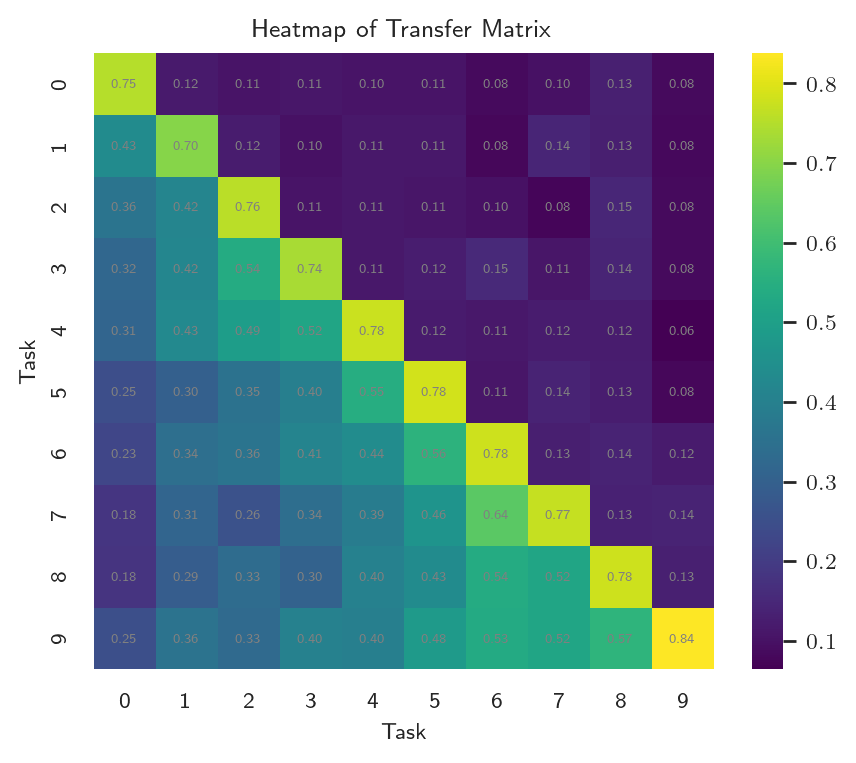

In [86]:

# Set annotation font size and color
annot_kws = {"size": 5, "color": "gray"}

# Plot the heatmap
plt.figure(figsize=(5, 4), dpi=200)
sns.heatmap(1 - matrix, annot=True, fmt=".2f", cmap="viridis", annot_kws=annot_kws)
plt.title("Heatmap of Transfer Matrix", fontsize=9)
plt.xlabel("Task")
plt.ylabel("Task")
plt.show()

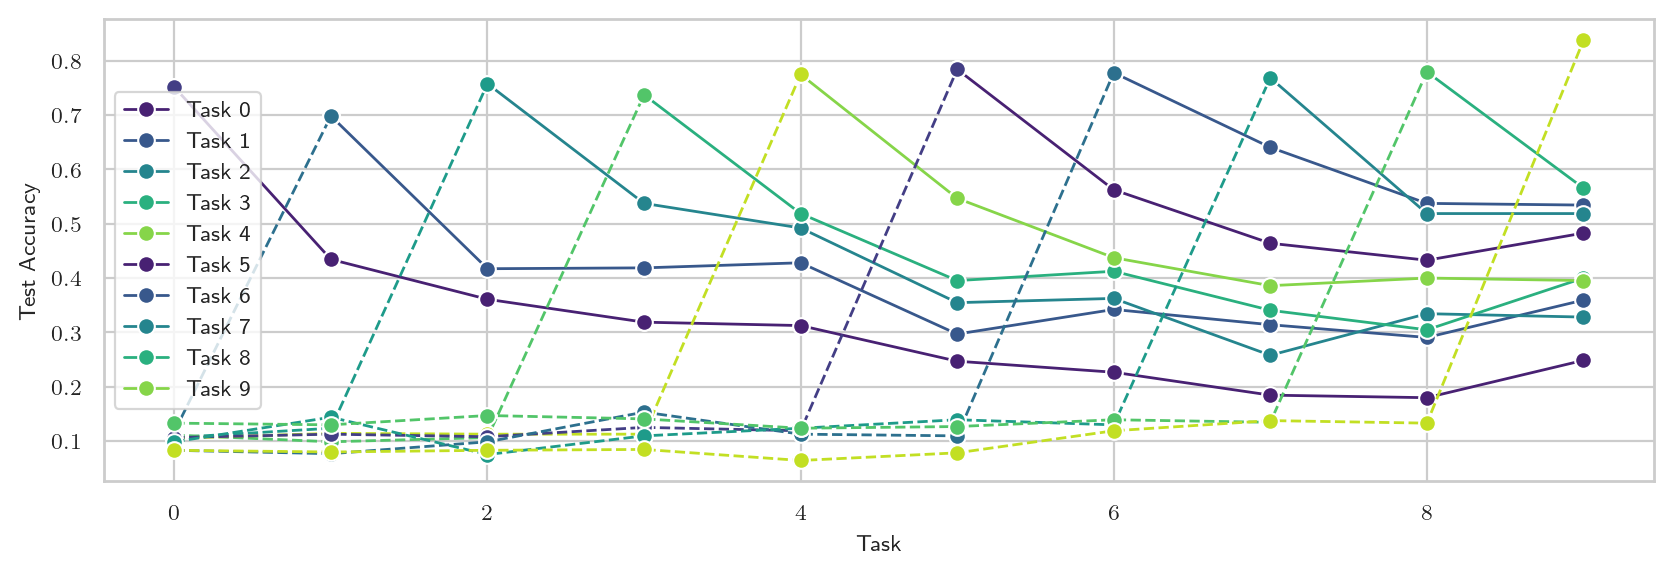

In [87]:
# Create a line plot for each row in the transfer matrix using seaborn
plt.figure(figsize=(10, 3), dpi=200)
palette = sns.color_palette("viridis", num_tasks)
sns.set_palette(palette)
for i in range(num_tasks):
    sns.lineplot(x=range(num_tasks)[i:], y=1-matrix[i:,i], label=f'Task {i}', linewidth=1, marker='o', markersize=6)
    sns.lineplot(x=range(num_tasks)[:i+1], y=1-matrix[:i+1,i], linestyle="--", linewidth=1, marker='o', markersize=6, label=None)
plt.xlabel('Task')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

## Parameter space investigation

In [88]:
from agents import get_agent_class_from_name
from utils import *
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataloader import DataLoader
from environments import get_environment_from_name

from hyperparameters import agent_hyperparameters

import importlib


In [89]:
import environments, agents
importlib.reload(environments)
importlib.reload(agents)
from environments import get_environment_from_name
from agents import get_agent_class_from_name

In [90]:
from evaluation import evaluate_agent_task

### Loading everything we need

In [91]:
acf = dotdict(config_df.iloc[0])
acf

{'network': 'resnet18',
 'optimizer': 'SGD',
 'lr': np.float64(0.05),
 'weight_decay': np.float64(1e-05),
 'momentum': np.float64(0.9),
 'step_scheduler_decay': np.int64(300),
 'cosine_scheduler_duration': np.float64(1.0),
 'scheduler_step': np.float64(0.1),
 'scheduler_type': 'cosine_anneal',
 'loss': 'CE',
 'batch_size': np.int64(150),
 'warmup_on': np.True_,
 'exp_id': 'exp2',
 'exp_timestamp': '20250319_180024',
 'exp_name': 'split-c100-classes-10_resnet18_base_multihead_singletask',
 'exp_type': 'singletask',
 'seed': np.int64(60),
 'steps_per_task': [1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000],
 'num_tasks': np.int64(10),
 'ordering': ['split_classes_10_0',
  'split_classes_10_1',
  'split_classes_10_2',
  'split_classes_10_3',
  'split_classes_10_4',
  'split_classes_10_5',
  'split_classes_10_6',
  'split_classes_10_7',
  'split_classes_10_8',
  'split_classes_10_9'],
 'environment': 'split-cifar100-classes-10',
 'agent_type': 'base',
 'num_cla

In [92]:
# Set random seed for reproducibility
seed = acf.seed; print(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

60


In [93]:
device = 3

acf.device = device
agent_class, _ = get_agent_class_from_name(acf.agent_type)
agent = agent_class(**acf)
agent_config = agent.config # collect the filled config (with all the agent- and experiment-related info)

Dynamic output mode.
Number of parameters 11.220132 MLN
Setup complete.


In [94]:
experiment_logger = ExperimentLogger(agent_config["exp_id"], agent_config["exp_timestamp"], agent_config["exp_name"], config=agent_config)

INFO:root:Training Configuration -base Agent: {'network': 'resnet18', 'optimizer': 'SGD', 'lr': np.float64(0.05), 'weight_decay': np.float64(1e-05), 'momentum': np.float64(0.9), 'step_scheduler_decay': np.int64(300), 'cosine_scheduler_duration': np.float64(1.0), 'scheduler_step': np.float64(0.1), 'scheduler_type': 'cosine_anneal', 'loss': 'CE', 'batch_size': np.int64(150), 'warmup_on': np.True_, 'exp_id': 'exp2', 'exp_timestamp': '20250319_180024', 'exp_name': 'split-c100-classes-10_resnet18_base_multihead_singletask', 'exp_type': 'singletask', 'seed': np.int64(60), 'steps_per_task': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'num_tasks': np.int64(10), 'ordering': ['split_classes_10_0', 'split_classes_10_1', 'split_classes_10_2', 'split_classes_10_3', 'split_classes_10_4', 'split_classes_10_5', 'split_classes_10_6', 'split_classes_10_7', 'split_classes_10_8', 'split_classes_10_9'], 'environment': 'split-cifar100-classes-10', 'agent_type': 'base', 'num_classes_per_tas

In [95]:
acf.environment
acf.split_type = "classes"
acf.number_tasks = acf.num_tasks

In [96]:
env, environment_name = get_environment_from_name("split", acf)

In [97]:
# labels = set()
# for x,y,t in DataLoader(env.environment['train']['split_classes_10_9']): 
#     labels.add(y.item())
# labels

# env.ordered_task_names


In [98]:
batches_eval = env.batches_eval
eval_criterion = env.criterion
num_classes_per_task = env.num_classes_per_task 
num_classes_total = env.num_classes

In [99]:
def get_multitask_dataloaders(env, task_id, batch_size): 
    # initializing task objective and training data iterator
    train_data = env.init_multi_task(number_of_tasks=task_id+1, train=True)
    train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

    # initialize training-time evaluation data 
    test_data = env.init_multi_task(number_of_tasks=task_id+1, train=False) # same test data for both agents
    test_data_loader = DataLoader(test_data, batch_size=128, shuffle=True, num_workers=4)

    return train_data_loader, test_data_loader

def get_singletask_dataloaders(env, task_id, batch_size): 
    # initializing task objective and training data iterator
    train_data = env.init_single_task(task_number=task_id, train=True)
    train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

    # initialize training-time evaluation data 
    test_data = env.init_single_task(task_number=task_id, train=False)
    test_data_loader = DataLoader(test_data, batch_size=128, shuffle=True, num_workers=4)

    return train_data_loader, test_data_loader

Take parameters from network

In [100]:
def get_params(net):
    # Initialize an empty list to store the parameters
    params_list = []

    # Iterate over all the parameters of the network and append them to the list
    for param in net.parameters():
        params_list.append(param.data.view(-1))

    # Concatenate the list to a single tensor
    params_vector = torch.cat(params_list)

    return params_vector

# Use the function to get parameters of the agent's network
params_vector = get_params(agent.network)
print(params_vector)

tensor([-0.1834, -0.0728,  0.1378,  ...,  0.0375,  0.0190, -0.0140],
       device='cuda:3')


Load checkpoint

In [101]:
experiment_logger.load_checkpoint(agent, 9)

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t9-s1000.pth
2025-03-21 18:07:52,752 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t9-s1000.pth
2025-03-21 18:07:52,752 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t9-s1000.pth


In [102]:
def evaluate_checkpoint(ckpt_task, data_task, agent, logger, env, train=False, batches=5): 
    agent = logger.load_checkpoint(agent, ckpt_task) # after first task
    agent.config['device'] = device
    train_dataloader, test_dataloader = get_singletask_dataloaders(env, data_task, 128)
    dataloader = train_dataloader if train else test_dataloader
    eval = evaluate_agent_task(batches, agent, iter(dataloader), eval_criterion, -1)
    return eval

In [103]:
evaluate_checkpoint(0, 0, agent, experiment_logger, env, train=False, batches=1)

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t0-s1000.pth
2025-03-21 18:07:52,851 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t0-s1000.pth
2025-03-21 18:07:52,851 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t0-s1000.pth


{'test_loss': 1.1219545602798462, 'test_error': 0.2265625}

### Distance measures

Basic distance measures

In [24]:
def get_norm_distance(m1, m2):
    return torch.norm(m1-m2, 2).item()


def get_cosine_similarity(m1, m2):
    cosine = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
    return cosine(m1, m2)

In [168]:
experiment_logger.load_checkpoint(agent, 1) # after first task
m1 = get_params(agent.network)
experiment_logger.load_checkpoint(agent, 10) # after last task 
m10 = get_params(agent.network)

get_norm_distance(m1, m10), get_cosine_similarity(m1, m10)

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t1-s9990.pth
2025-03-13 17:49:18,059 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t1-s9990.pth
2025-03-13 17:49:18,059 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t1-s9990.pth
INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t10-s99990.pth
2025-03-13 17:49:23,380 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-longertask-20250311_191525//checkpoints/exp1-longertask-t10-s99990.pth
2025-03-13 17:49:23,380 - Loading model checkpoint from ./experiments/split-c1

(82.62105560302734, tensor(0.7088))

In [166]:
minima = []
for i in range(num_tasks):
    experiment_logger.load_checkpoint(agent, i)
    minima.append(get_params(agent.network))

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-20_resnet18_base_multihead_multitask-exp1-moretasks-20250314_233250//checkpoints/exp1-moretasks-t0-s1000.pth
2025-03-17 18:31:36,453 - Loading model checkpoint from ./experiments/split-c100-classes-20_resnet18_base_multihead_multitask-exp1-moretasks-20250314_233250//checkpoints/exp1-moretasks-t0-s1000.pth
2025-03-17 18:31:36,453 - Loading model checkpoint from ./experiments/split-c100-classes-20_resnet18_base_multihead_multitask-exp1-moretasks-20250314_233250//checkpoints/exp1-moretasks-t0-s1000.pth
2025-03-17 18:31:36,453 - Loading model checkpoint from ./experiments/split-c100-classes-20_resnet18_base_multihead_multitask-exp1-moretasks-20250314_233250//checkpoints/exp1-moretasks-t0-s1000.pth
2025-03-17 18:31:36,453 - Loading model checkpoint from ./experiments/split-c100-classes-20_resnet18_base_multihead_multitask-exp1-moretasks-20250314_233250//checkpoints/exp1-moretasks-t0-s1000.pth
INFO:root:Loading model ch

In [167]:
# Initialize the distance matrices
l2_distance = np.zeros((num_tasks, num_tasks))
cosine_distance = np.zeros((num_tasks, num_tasks))

# Populate the l2_distance matrix
for i in range(num_tasks):
    mi = minima[i]
    for j in range(num_tasks):
        mj = minima[j]
        l2_distance[i, j] = get_norm_distance(mi, mj)
        cosine_distance[i, j] = get_cosine_similarity(mi, mj)

In [168]:
l2_distance

array([[ 0.        , 14.15949059, 21.6301384 , 30.27783394, 30.98778343,
        32.73787689, 34.3872757 , 36.81199646, 37.66352844, 38.7463913 ,
        39.32558441, 40.4849205 , 41.12003708, 41.82087708, 42.47377014,
        43.95286942, 49.76564789, 50.75366211, 51.08209991, 51.34397888],
       [14.15949059,  0.        , 14.14621258, 24.14194679, 24.99218178,
        26.99551201, 28.87078094, 31.55792809, 32.53334045, 33.74044037,
        34.40473175, 35.69183731, 36.40898895, 37.19200134, 37.91637039,
        39.51443481, 45.67591095, 46.71847916, 47.08937836, 47.39162064],
       [21.6301384 , 14.14621258,  0.        , 17.87108994, 18.91123772,
        21.31159973, 23.50250816, 26.50558662, 27.64402962, 29.00556564,
        29.78071594, 31.21698952, 32.02417755, 32.89512634, 33.71695328,
        35.42453003, 41.94020081, 43.03776169, 43.45892334, 43.80543137],
       [30.27783394, 24.14194679, 17.87108994,  0.        ,  6.25103998,
        11.44759941, 14.97490025, 19.04832649, 2

Text(0.5, 1.0, 'L2 distance')

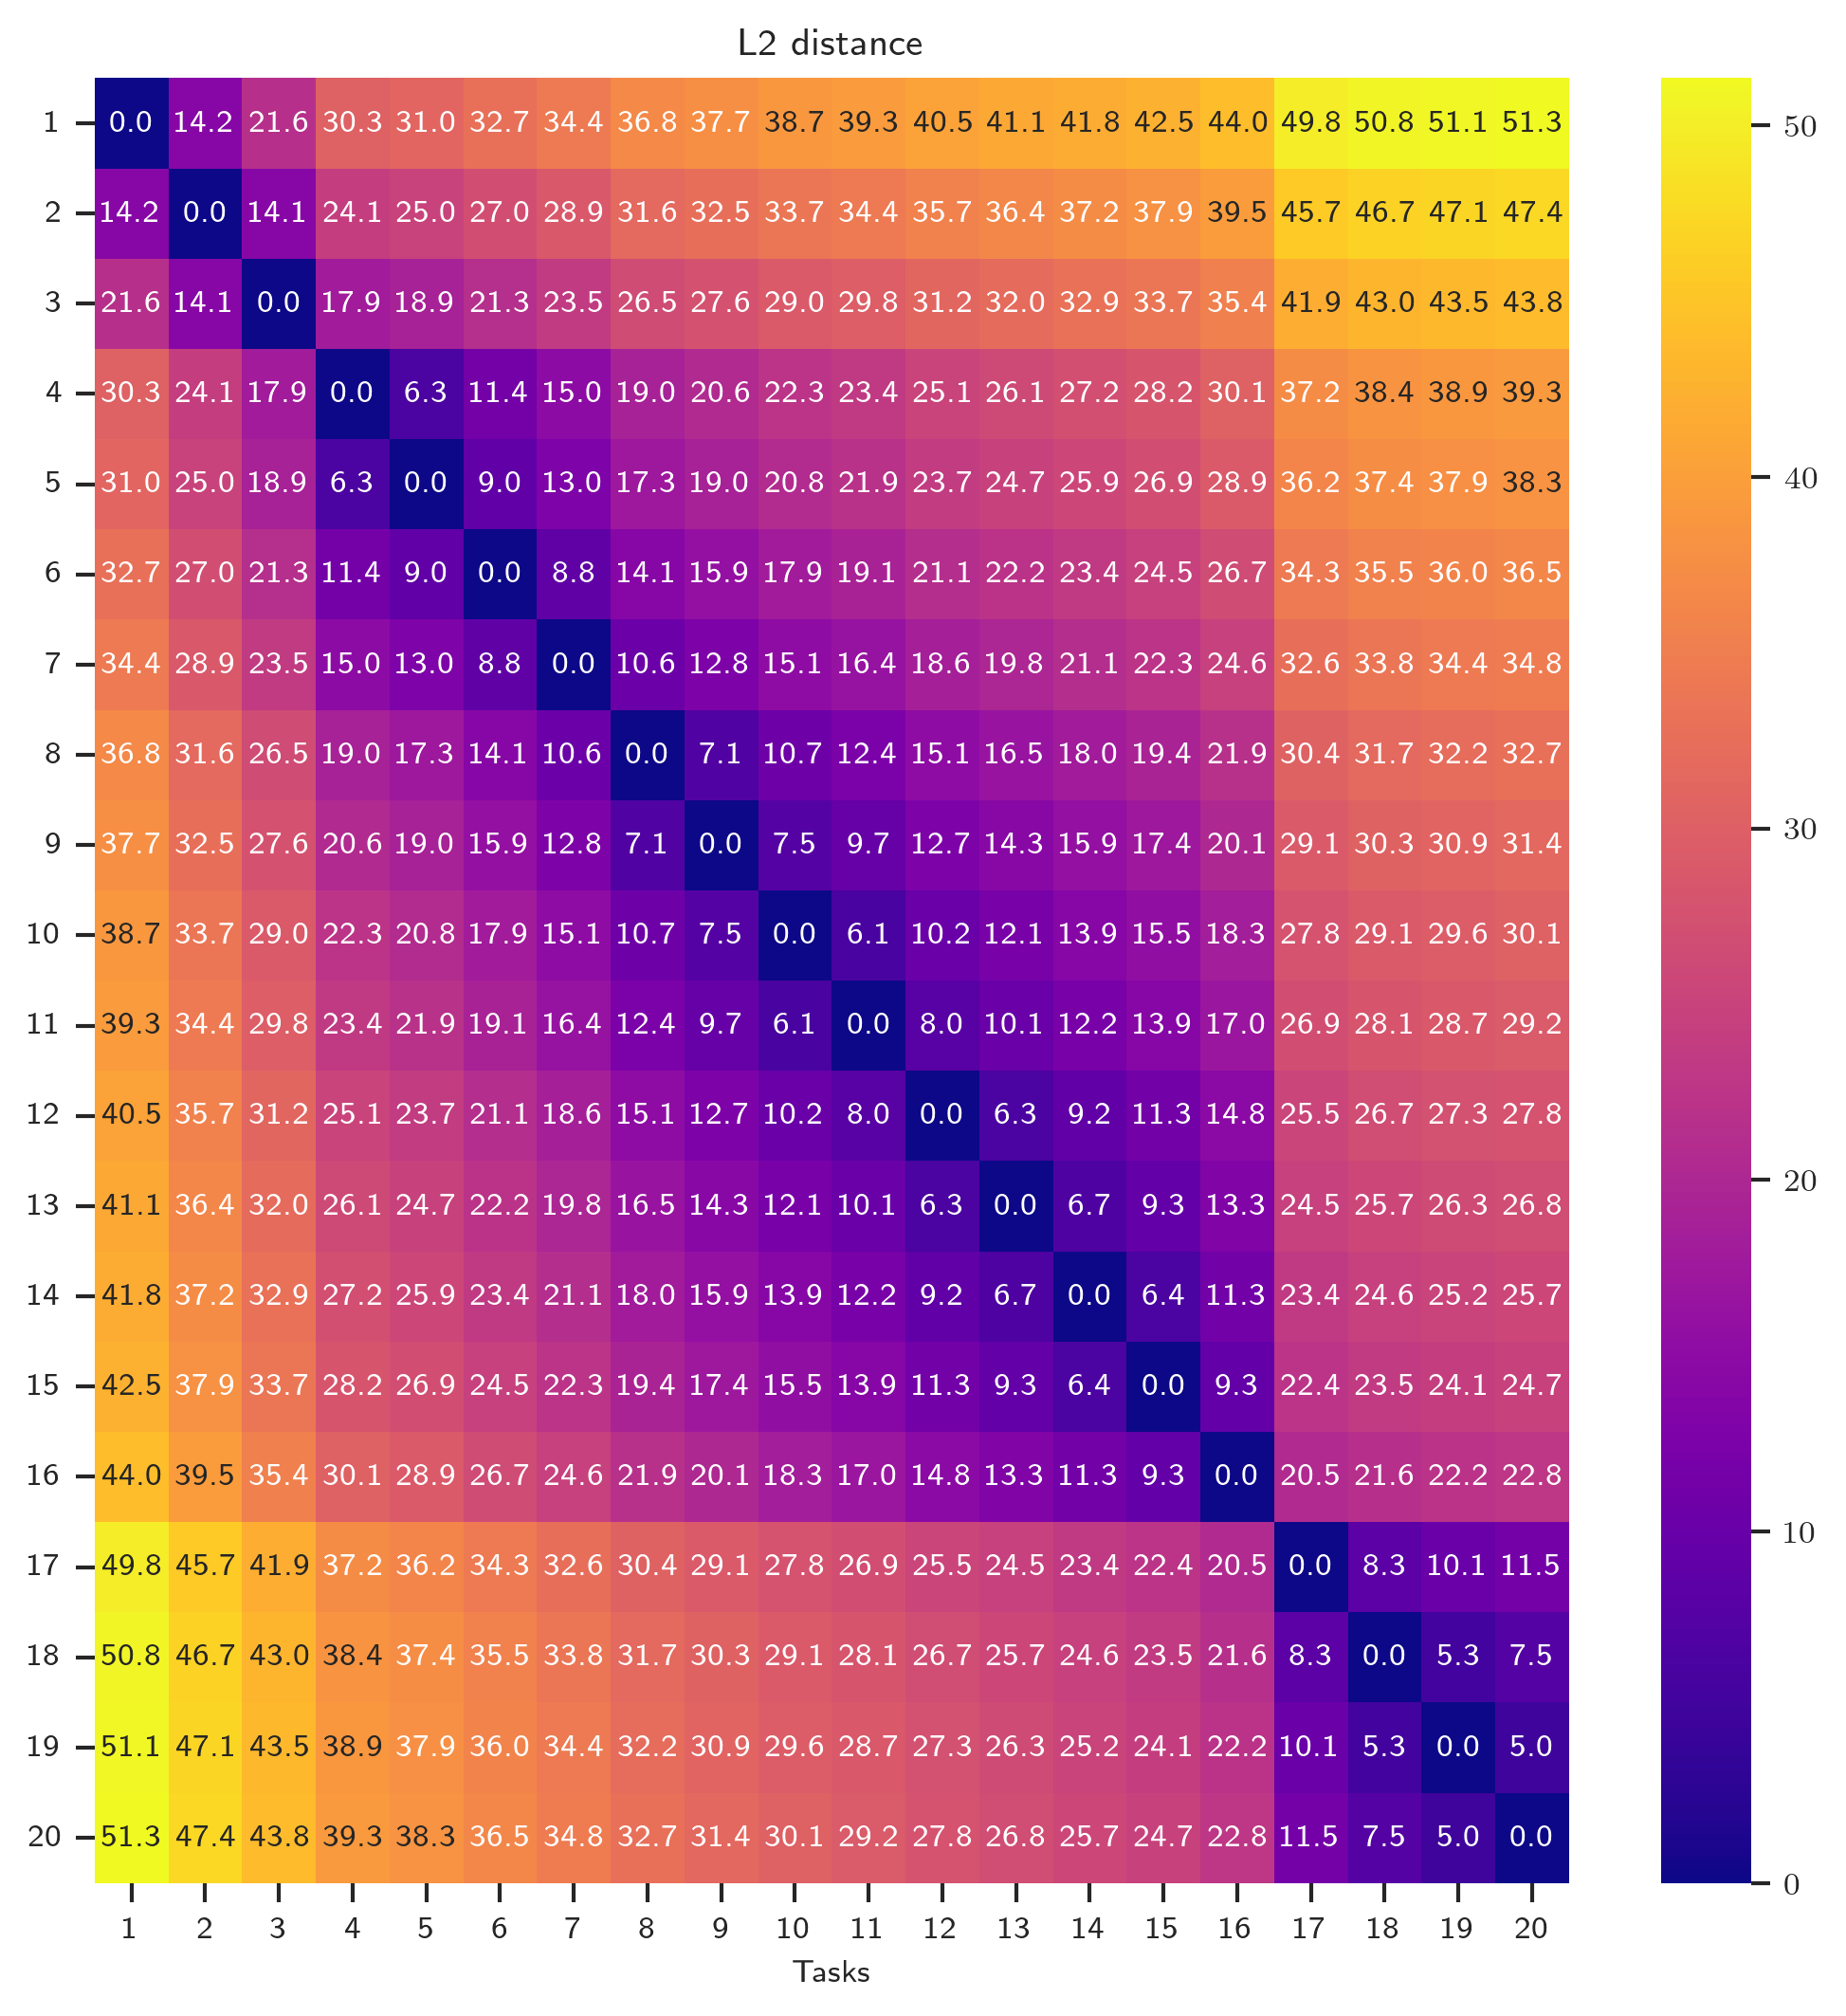

In [ ]:


import matplotlib

matrix = l2_distance
labels = [i+1 for i in range(num_tasks)]



plt.figure(figsize=(7, 7), dpi=300)

ax = sns.heatmap(matrix, annot=True, fmt='.1f', cbar=True, \
    xticklabels=labels, yticklabels=labels,\
    annot_kws={'size': 8}, cmap='plasma')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
plt.xlabel(r'Tasks')
plt.tight_layout()
plt.title("L2 distance")
# ax.get_figure().savefig(path+'.png', dpi=200)
# ax.get_figure().savefig(path+'.pdf', dpi=200)
# plt.close()

In [172]:
ax.get_figure().savefig('figures/L21000more.pdf', dpi=200, bbox_inches='tight')

Text(0.5, 1.0, 'Cosine distance')

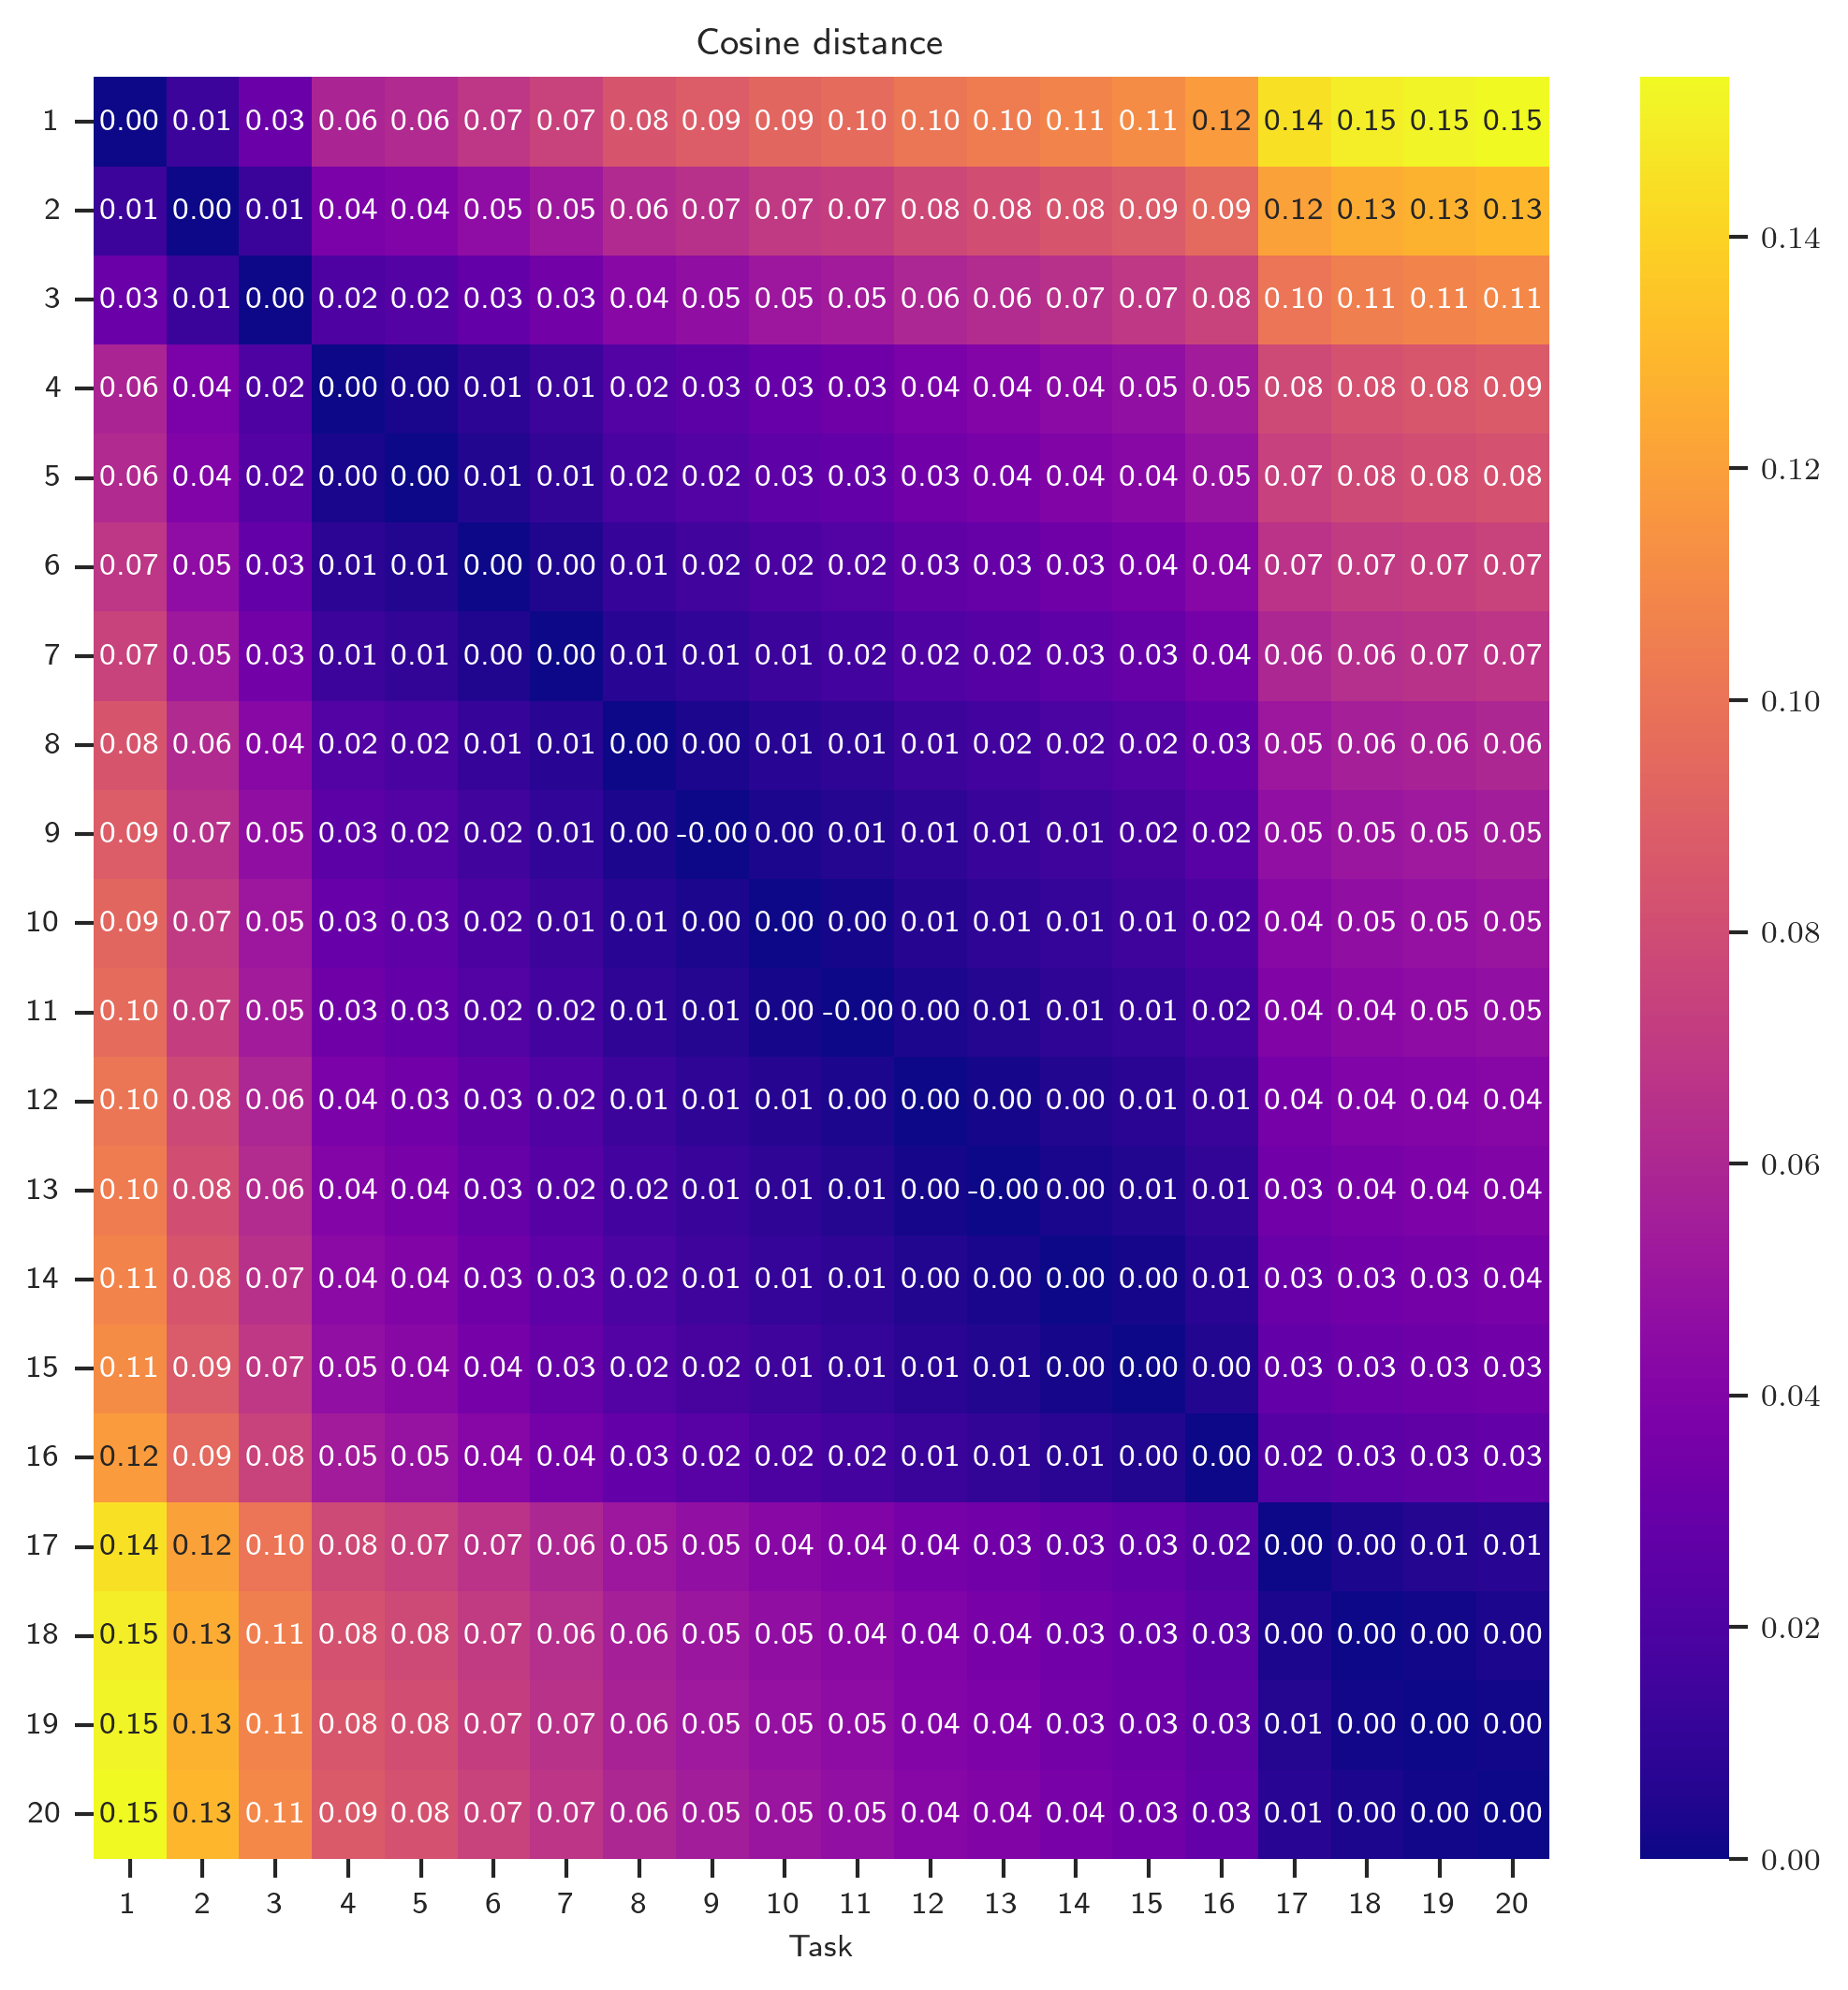

In [ ]:


import matplotlib

matrix = 1 - cosine_distance
labels = [i+1 for i in range(num_tasks)]


plt.figure(figsize=(7, 7), dpi=300)

ax = sns.heatmap(matrix, annot=True, fmt='.2f', cbar=True, \
    xticklabels=labels, yticklabels=labels,\
    annot_kws={'size': 8}, cmap='plasma')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
plt.xlabel(r'Task')
plt.tight_layout()
plt.title("Cosine distance")
# ax.get_figure().savefig(path+'.png', dpi=200)
# ax.get_figure().savefig(path+'.pdf', dpi=200)
# plt.close()

In [174]:
ax.get_figure().savefig('figures/cosine1000more.pdf', dpi=200, bbox_inches='tight')

CKA distance

In [31]:
# from https://github.com/google-research/google-research/blob/master/representation_similarity/Demo.ipynb 
import copy
import numpy as np

def gram_linear(x):
  """Compute Gram (kernel) matrix for a linear kernel.

  Args:
    x: A num_examples x num_features matrix of features.

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  return x @ x.T


def gram_rbf(x, threshold=1.0):
  """Compute Gram (kernel) matrix for an RBF kernel.

  Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  dot_products = x.dot(x.T)
  sq_norms = np.diag(dot_products)
  sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
  sq_median_distance = np.median(sq_distances)
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
  """Center a symmetric Gram matrix.

  This is equvialent to centering the (possibly infinite-dimensional) features
  induced by the kernel before computing the Gram matrix.

  Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

  Returns:
    A symmetric matrix with centered columns and rows.
  """
  if not torch.allclose(gram, gram.T):
    raise ValueError('Input must be a symmetric matrix.')
  gram = copy.deepcopy(gram)

  if unbiased:
    # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
    # L. (2014). Partial distance correlation with methods for dissimilarities.
    # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
    # stable than the alternative from Song et al. (2007).
    n = gram.shape[0]
    torch.fill_diagonal(gram, 0)
    means = torch.sum(gram, 0, dtype=torch.float64) / (n - 2)
    means -= torch.sum(means) / (2 * (n - 1))
    gram -= means[:, None]
    gram -= means[None, :]
    torch.fill_diagonal(gram, 0)
  else:
    means = torch.mean(gram, 0, dtype=torch.float64)
    means -= torch.mean(means) / 2
    gram -= means[:, None]
    gram -= means[None, :]

  return gram


def cka(gram_x, gram_y, debiased=False):
  """Compute CKA.

  Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

  Returns:
    The value of CKA between X and Y.
  """
  gram_x = center_gram(gram_x, unbiased=debiased)
  gram_y = center_gram(gram_y, unbiased=debiased)

  # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
  # n*(n-3) (unbiased variant), but this cancels for CKA.
  scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

  normalization_x = torch.linalg.norm(gram_x)
  normalization_y = torch.linalg.norm(gram_y)
  return scaled_hsic / (normalization_x * normalization_y)


In [59]:
num_batches = 5

# choose a dataset (say task 1)
train_dataloader, test_dataloader = get_multitask_dataloaders(env, 9, 128)
# for each task load the corresponding network weights and compute the features on that dataset at every layer
all_tasks_feats = []# num_tasks x num_layers x N x D 
for i in range(num_tasks): 
    agent = experiment_logger.load_checkpoint(agent, i) # after first task
    features={}; total=0
    for x, y, task_id in test_dataloader: 
        if total >= 128*num_batches: break
        agent.ready_eval()
        x = x.to(device)
        #x, y, task_id = next(iter(test_dataloader))
        total+=len(y)
        with torch.no_grad():
            feats, _ = agent.network.get_features(x, return_intermediate=True)
             # num_layers x N x D 
        for l, phi in enumerate(feats): 
            if l in features.keys():
                features[l].append(phi.view(128,-1)) # flatten
            else: features[l] = [phi.view(128,-1)] # flatten
    
    all_tasks_feats.append(features)
            


INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp1-20250314_171721//checkpoints/exp1-t0-s1000.pth
2025-03-17 19:35:22,061 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp1-20250314_171721//checkpoints/exp1-t0-s1000.pth
2025-03-17 19:35:22,061 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp1-20250314_171721//checkpoints/exp1-t0-s1000.pth
INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp1-20250314_171721//checkpoints/exp1-t1-s1000.pth
2025-03-17 19:35:22,801 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp1-20250314_171721//checkpoints/exp1-t1-s1000.pth
2025-03-17 19:35:22,801 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp1-20250

In [60]:
# compute the pairwise CKA at every layer of the network  
# Initialize the distance matrices
cka_distances = [np.zeros((num_tasks, num_tasks)) for l in range(len(features))]
for l in features.keys():
    for i in range(num_tasks):
        X_i = torch.cat(all_tasks_feats[i][l], dim=0)
        for j in range(num_tasks):
            X_j = torch.cat(all_tasks_feats[j][l], dim=0)
            cka_distances[l][i,j] = cka(gram_linear(X_i), gram_linear(X_j))

In [61]:
layers = len(cka_distances)

Text(0.5, 1.01, 'CKA similarity by layers on all tasks data')

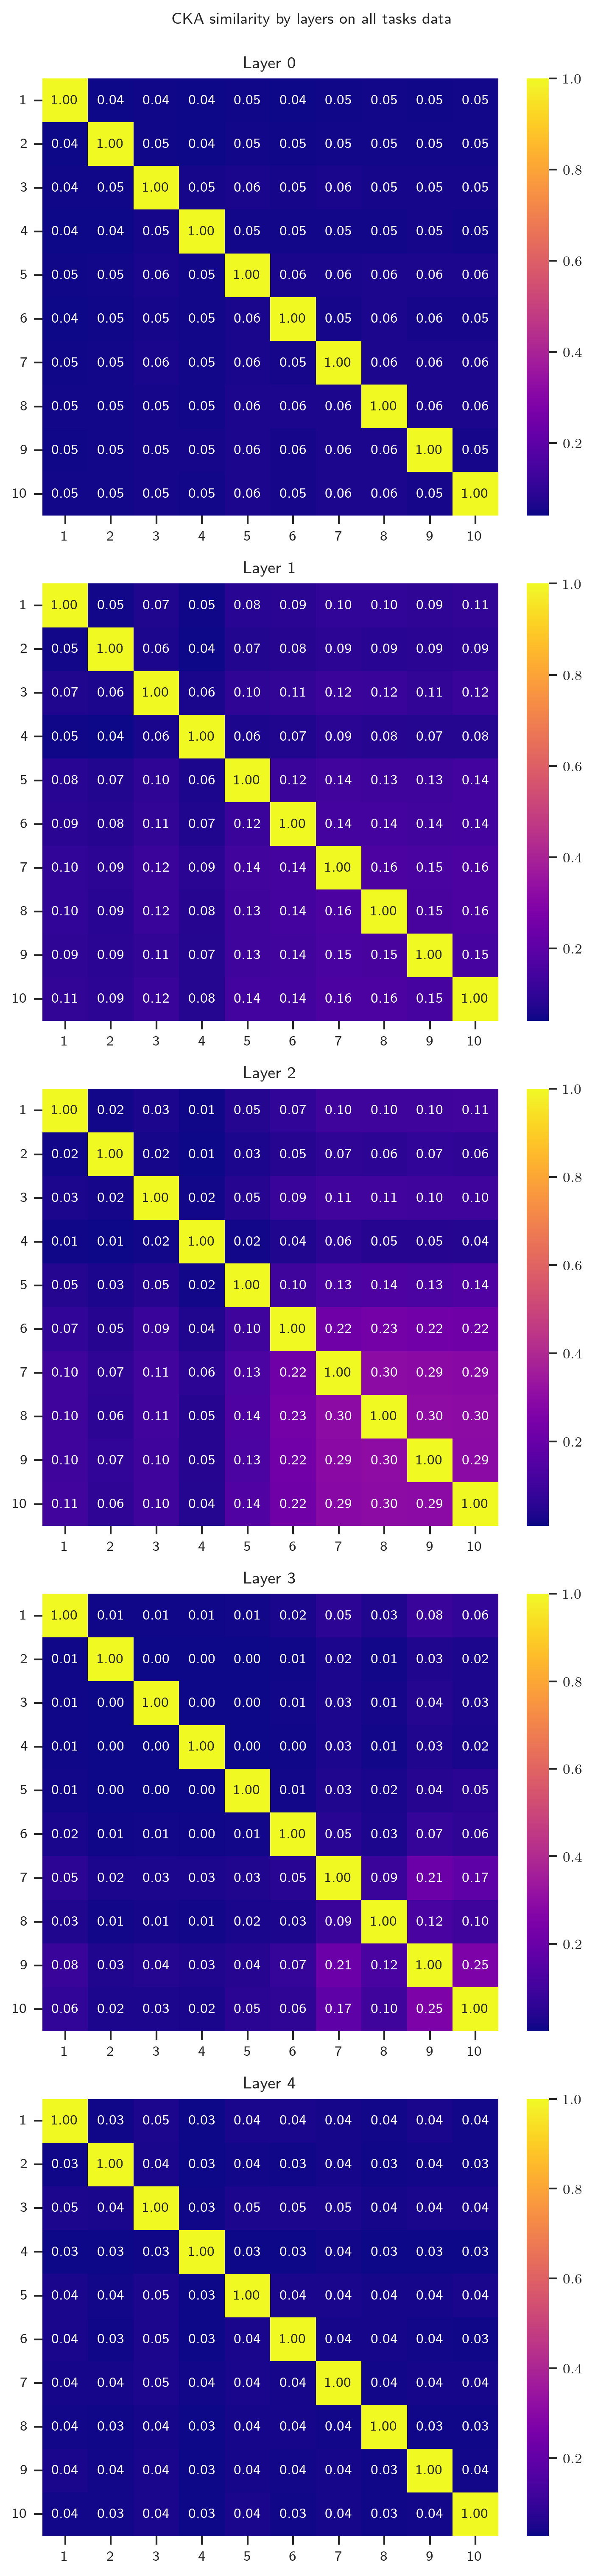

In [63]:

matrices = cka_distances
labels = [i+1 for i in range(num_tasks)]


fig, axes = plt.subplots(layers, 1, figsize=(5, 20), dpi=300)

for l in range(layers): 
    ax = axes[l]

    ax = sns.heatmap(matrices[l], annot=True, fmt='.2f', cbar=True, \
        xticklabels=labels, yticklabels=labels,\
        annot_kws={'size': 8}, cmap='plasma', ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
    ax.set_title(f'Layer {l}')

plt.tight_layout()
fig.suptitle("CKA similarity by layers on all tasks data", fontsize=9, y = 1.01)
# ax.get_figure().savefig(path+'.png', dpi=200)
# ax.get_figure().savefig(path+'.pdf', dpi=200)
# plt.close()

In [64]:
fig.get_figure().savefig('figures/CKA1000single_alltasks.pdf', dpi=200, bbox_inches='tight')

### Linear Mode Connectivity

In [104]:
def reset_batchnorm(module):
    if isinstance(module, torch.nn.BatchNorm2d):  
        module.running_mean = torch.zeros_like(module.running_mean)
        module.running_var = torch.ones_like(module.running_var)
        

In [105]:
def has_batch_norm(net):
    for n, p in net.named_modules():
        if isinstance(p, torch.nn.BatchNorm2d): return True
    return False

In [106]:
from tqdm import tqdm


def linear_interpolation(start, end, agent, dataloader, line_samples=10, tasks_learned=-1, batches=10, return_type="loss"): 
    loss = [] 
    line_range = np.arange(0.0, 1.01, 1.0/float(line_samples))

  
    direction = end - start
    print(direction.max())
    
    for t in tqdm(line_range, desc="Interpolating"):
        cur_weight = start + (direction * t)
        agent.network.assign_weights(cur_weight.to(device))
        agent.config['device'] = device
        if has_batch_norm(agent.network): 
            torch.optim.swa_utils.update_bn(iter(dataloader), agent.network, device)
            
        current_loss = evaluate_agent_task(batches, agent, iter(dataloader), eval_criterion, tasks_learned)[f'test_{return_type}']
        loss.append(current_loss)
    return loss, line_range

In [107]:
def plot_single_interpolation(x, y, measure="Validation", label=""):
    plt.figure(figsize=(5, 3), dpi=200)
    sns.set(style="whitegrid")
    sns.set_context("paper",rc={"lines.linewidth": 2,
                    'xtick.labelsize':8,
                    'ytick.labelsize':8,
                    'lines.markersize' : 100,
                    'lines.markers' : 'o',
                    'legend.fontsize': 8,
                    'axes.labelsize': 8,
                    'legend.handlelength': 1,
                    'legend.handleheight':1,})

    color = 'orange'
    suffix = 'loss'
    sns.lineplot(x=x, y=y, color=color, label=label)
    plt.xlabel('Interpolation')
    plt.ylabel('{} {}'.format(measure, suffix))
    # plt.title(title)
    # plt.ylim((0.0, 0.005))
    plt.tight_layout()
    plt.show()

In [28]:
agent = experiment_logger.load_checkpoint(agent, 0) # after first task
start = get_params(agent.network).to(device).clone()

agent = experiment_logger.load_checkpoint(agent, 1) # after first task
end = get_params(agent.network).to(device).clone()

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_multitask-exp2-20250320_124048//checkpoints/exp2-t0-s1000.pth
2025-03-21 17:14:12,796 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_multitask-exp2-20250320_124048//checkpoints/exp2-t0-s1000.pth
INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_multitask-exp2-20250320_124048//checkpoints/exp2-t1-s1000.pth
2025-03-21 17:14:12,943 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_multitask-exp2-20250320_124048//checkpoints/exp2-t1-s1000.pth


tensor(0.3225, device='cuda:0')


Interpolating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


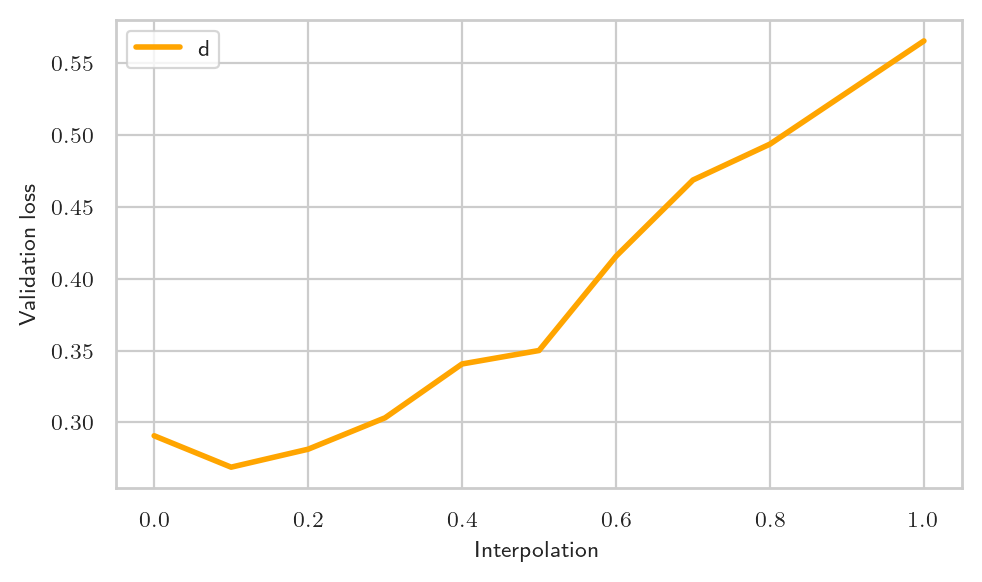

In [29]:
# linear mode connectivity on loss of task 1 between task 1 and task 2 solutions

train_dataloader, test_dataloader = get_singletask_dataloaders(env, 0, 128)

# # train data
# l_values, x_values = linear_interpolation(m1, m2, agent, train_dataloader, line_samples=10, tasks_learned=-1, batches=5, return_type="error")
# plot_single_interpolation(x_values, l_values, measure="Training", label="d")

# test data 
l_values, x_values = linear_interpolation(start, end, agent, test_dataloader, line_samples=10, tasks_learned=-1, batches=5, return_type="error")
plot_single_interpolation(x_values, l_values, measure="Validation", label="d")

From 1 to all the others

In [108]:
minima = []
for i in range(num_tasks):
    experiment_logger.load_checkpoint(agent, i)
    minima.append(get_params(agent.network).to(device))
agent.config['device']=device

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t0-s1000.pth
2025-03-21 18:07:54,780 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t0-s1000.pth
2025-03-21 18:07:54,780 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t0-s1000.pth
INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t1-s1000.pth
2025-03-21 18:07:54,890 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t1-s1000.pth
2025-03-21 18:07:54,890 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250

In [109]:
train_dataloader, test_dataloader = get_singletask_dataloaders(env, 0, 128)
# Initialize the loss matrix
line_samples=10
l_values_all = np.zeros((num_tasks, line_samples+1))

# Populate the loss matrix
m1 = minima[0]
for i in range(num_tasks):
    mi = minima[i]
    l_values, x_values = linear_interpolation(m1, mi, agent, test_dataloader, line_samples=line_samples, tasks_learned=-1, batches=4, return_type="loss")
    l_values_all[i,:] = l_values

tensor(0., device='cuda:3')


Interpolating:  27%|██▋       | 3/11 [00:04<00:11,  1.49s/it]Exception ignored in: <function _releaseLock at 0x7f86577ac820>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Interpolating: 100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


tensor(0.2953, device='cuda:3')


Interpolating:  27%|██▋       | 3/11 [00:04<00:11,  1.49s/it]Exception ignored in: <function _releaseLock at 0x7f86577ac820>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Interpolating:  27%|██▋       | 3/11 [00:10<00:29,  3.66s/it]


RuntimeError: DataLoader worker (pid(s) 2659994, 2659997) exited unexpectedly

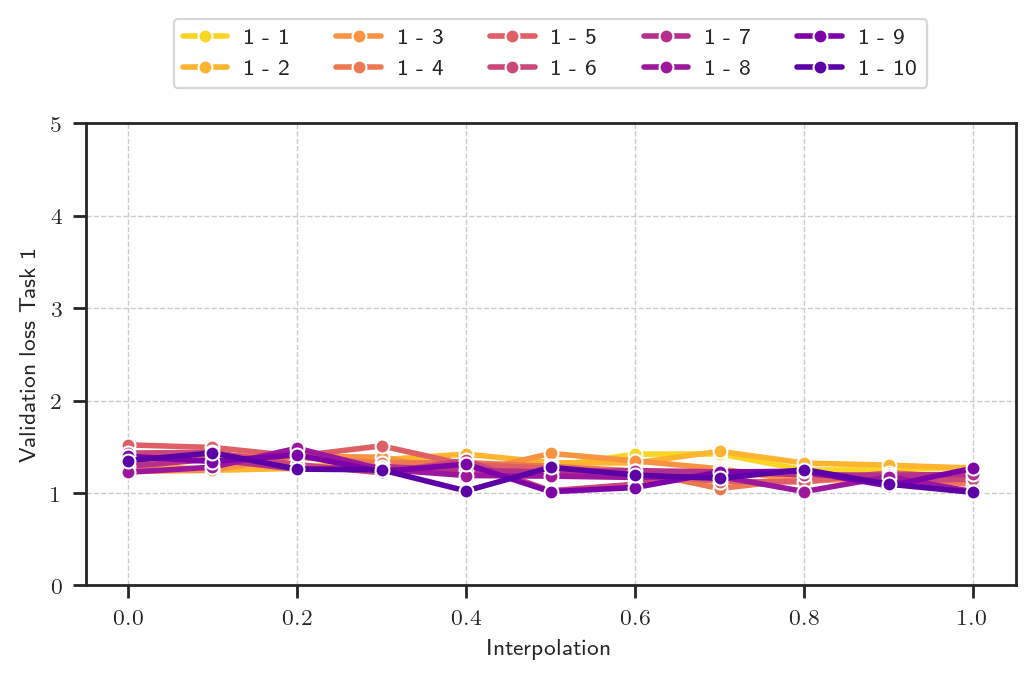

In [31]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

sns.set(style="whitegrid")
sns.set_context("paper",
                rc={"lines.linewidth": 2,
                'xtick.labelsize':8,
                'ytick.labelsize':8,
                'lines.markersize' : 5,
                'lines.marker' : 'o',
                'legend.fontsize': 8,
                'axes.labelsize': 8,
                'legend.handlelength': 1,
                'legend.handleheight':1,})

                
palette = sns.color_palette("plasma_r", num_tasks+1)
suffix = 'loss'
for i in range(num_tasks): 
    sns.lineplot(x=x_values, y=l_values_all[i,:], color=palette[i], label=f"1 - {i+1}", marker='o')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('Interpolation')
ax.set_ylabel('Validation {} Task 1'.format(suffix))
ax.set_ylim((0.0, 5))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5, fontsize='small')
plt.show()

In [98]:
fig.savefig('figures/LMC1000MT.pdf', dpi=200, bbox_inches='tight')

## Hessian and 2nd order approximations

Attempt 1

In [24]:
N = 100

agent = experiment_logger.load_checkpoint(agent, 0) # after first tas
agent.config['device']=device
agent.network = agent.network.to(device)
train_dataloader, test_dataloader = get_singletask_dataloaders(env, 0, N)

data = iter(train_dataloader).__next__()

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t0-s1000.pth
2025-03-19 17:10:37,721 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t0-s1000.pth


In [ ]:
from torch.amp import autocast

def hessian_vector_product(grad, params, vectors):
    """Compute batched Hessian-vector product (HVP) using autograd."""
    valid_params = [p for p in params if p.requires_grad]  # Filter only used parameters
    hvps = torch.autograd.grad(grad, valid_params, grad_outputs=vectors, retain_graph=True, allow_unused=True)
    hvps = [(g if g is not None else torch.zeros_like(p)) for g, p in zip(hvps, valid_params)]  # Handle unused params
    # Check for NaNs
    # if any(g is not None and torch.isnan(g).any() for g in hvps):
    #     print("NaN detected in Hessian-vector product!")
    #     return None
    return torch.cat([g.flatten() for g in hvps], dim=0)  # Concatenate valid HVPs

def top_k_hessian_eigen(agent, criterion, data, K=5, ntasks_observed=-1):
    """GPU-optimized computation of top-K Hessian eigenvalues and eigenvectors using Lanczos."""
    agent.ready_train()
    agent.network.zero_grad()
    x, y, task_id = data
    x, y = x.to(device), y.to(device)
    
    
    with autocast(device_type=f"cuda:{device}"):  # Mixed precision for better performance
        out,y = agent.predict((x,y,task_id), ntasks_observed)
        loss = criterion(out, y)
    
    grads = torch.autograd.grad(loss, [p for p in agent.network.parameters() if p.requires_grad], create_graph=True, allow_unused=True)
    grads = [g if g is not None else torch.zeros_like(p) for g, p in zip(grads, agent.network.parameters()) if p.requires_grad]
    # if any(torch.isnan(g).any() for g in grads if g is not None):
    #     print("NaN detected in first-order gradients (grad_vector)!")
    #     return None, None
    grad_vector = torch.cat([g.flatten() for g in grads])  # Convert to vector
    N = grad_vector.shape[0]  # Number of parameters


    # Initialize Krylov subspace
    Q = torch.zeros((N, K), device=device, dtype=torch.float32)
    T = torch.zeros((K, K), device=device, dtype=torch.float32)
    
    q = torch.randn(N, device=device, dtype=torch.float32)
    q /= q.norm() + 1e-8  # Prevent division by zero
    
    
    for k in range(K):
        Q[:, k] = q
        print("q: ",q.abs().min())
        Hv = hessian_vector_product(grad_vector, list(agent.network.parameters()), q)
        # Check for NaNs and replace them with small values
        if torch.isnan(Hv).any():
            print(f"NaN detected in Hv at iteration {k} ")
            Hv = torch.nan_to_num(Hv, nan=1e-8)  # Replace NaNs with small values
    
        # if torch.isnan(Hv).any():
        #     print(f"NaN detected in Hv at iteration {k}")
        #     return None, None  # Abort early
        
        if k > 0:
            Hv -= T[k - 1, k] * Q[:, k - 1]  # Orthogonalization
        
        alpha = torch.dot(Hv, q)
        T[k, k] = alpha
        Hv -= alpha * q

        
        beta = Hv.norm()

        if k < K - 1:
            T[k, k + 1] = beta
            T[k + 1, k] = beta
            q = Hv / beta
    
    # Compute eigenvalues and eigenvectors of the small KxK matrix
    T = (T + T.T) / 2  # Force symmetry
    # T += torch.eye(K, device=T.device) * 1e-6 # Small perturbations
    eigvals, eigvecs = torch.linalg.eigh(T.cpu())
    eigvecs_full = Q @ eigvecs.to(device)  # Map back to full space
    
    return eigvals, eigvecs_full


Attempt 2

In [110]:
N = 100

agent = experiment_logger.load_checkpoint(agent, 0) # after first tas
agent.config['device']=device
agent.network= agent.network.to(device)
train_dataloader, test_dataloader = get_singletask_dataloaders(env, 0, N)

data = iter(train_dataloader).__next__()

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t0-s1000.pth
2025-03-21 18:08:28,044 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t0-s1000.pth
2025-03-21 18:08:28,044 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead_singletask-exp2-20250319_180024//checkpoints/exp2-t0-s1000.pth


In [111]:
K=100

In [112]:

from scipy.sparse.linalg import LinearOperator, eigsh

agent.ready_train()
model = agent.network

x, y, task_id = data
x, y = x.to(device), y.to(device)

def compute_loss(x, y, task_id):
    out, y_pred = agent.predict((x, y, task_id), -1)
    loss = eval_criterion(out, y_pred)
    return loss

def param_extract_fn(model): 
    return [p for p in model.parameters() if p.requires_grad] 

def hessian_vector_product(vector, x, y, task_id):
    model.zero_grad()
    grad_params = torch.autograd.grad(compute_loss(x, y, task_id), param_extract_fn(model), create_graph=True, allow_unused=True)
    # handle unused parameters 
    grad_params = [g if g is not None else torch.zeros_like(p) for g, p in zip(grad_params, param_extract_fn(model))]
    flat_grad = torch.cat([g.view(-1) for g in grad_params])

    grad_vector_product = torch.sum(flat_grad * vector)
    hvp = torch.autograd.grad(grad_vector_product, param_extract_fn(model), retain_graph=True, allow_unused=True, only_inputs=True)
    hvp = [(g if g is not None else torch.zeros_like(p)) for g, p in zip(hvp, param_extract_fn(model))]
    return torch.cat([g.contiguous().view(-1) for g in hvp])

def matvec(v, x, y, task_id):
    v_tensor = torch.tensor(v, dtype=torch.float32, device=device)
    return hessian_vector_product(v_tensor, x, y, task_id).cpu().detach().numpy()

num_params = sum(p.numel() for p in param_extract_fn(model))
linear_operator = LinearOperator((num_params, num_params), matvec=lambda v: matvec(v, x, y, task_id))
eigenvalues, eigenvectors = eigsh(linear_operator, k=K, tol=0.001, which='LM', return_eigenvectors=True)
eigenvectors = np.transpose(eigenvectors)


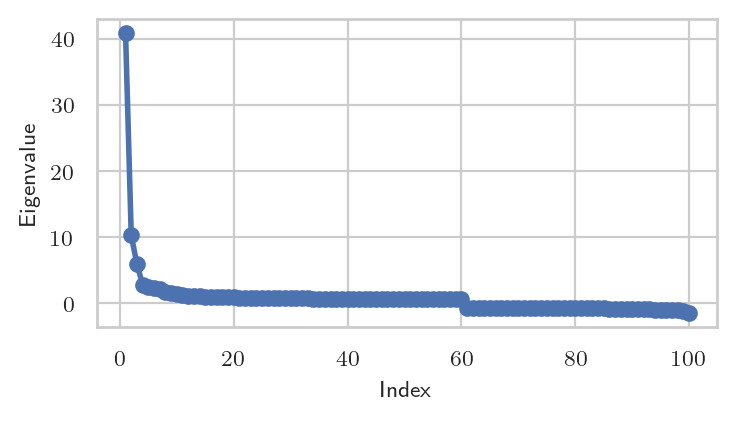

In [113]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=200)
eigenvalues = eigenvalues[::-1]
eigenvectors = eigenvectors[::-1]

plt.plot(range(1, K+1), eigenvalues, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [114]:

fig.savefig('figures/Spectrum1000ST.pdf', dpi=200, bbox_inches='tight')

Attempt 3

In [31]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(device)
from pyhessian import hessian # Hessian computation

In [32]:
N = 100

agent = experiment_logger.load_checkpoint(agent, 0) # after first tas
agent.config['device']=device
agent.network = agent.network.to(device)
train_dataloader, test_dataloader = get_singletask_dataloaders(env, 0, N)

data = iter(train_dataloader).__next__()

INFO:root:Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t0-s1000.pth
2025-03-19 18:14:39,407 - Loading model checkpoint from ./experiments/split-c100-classes-10_resnet18_base_multihead-exp1-20250314_121833//checkpoints/exp1-t0-s1000.pth


In [33]:
# Adapted from https://github.com/amirgholami/PyHessian/blob/master/pyhessian/hessian.py

from pyhessian.utils import group_product, group_add, normalization, get_params_grad, hessian_vector_product, orthnormal

def compute_loss(x, y, task_id):
    out, y_pred = agent.predict((x, y, task_id), -1)
    loss = eval_criterion(out, y_pred)
    return loss

def param_extract_fn(model): 
    return [p for p in model.parameters() if p.requires_grad] 

def hessian_vector_product(vector, x, y, task_id):
    model.zero_grad()
    grad_params = torch.autograd.grad(compute_loss(x, y, task_id), param_extract_fn(model), create_graph=True, allow_unused=True)
    # handle unused parameters 
    grad_params = [g if g is not None else torch.zeros_like(p) for g, p in zip(grad_params, param_extract_fn(model))]
    flat_grad = torch.cat([g.view(-1) for g in grad_params])

    grad_vector_product = flat_grad @ vector
    hvp = torch.autograd.grad(grad_vector_product, param_extract_fn(model), retain_graph=True, allow_unused=True, only_inputs=True)
    hvp = [(g if g is not None else torch.zeros_like(p)) for g, p in zip(hvp, param_extract_fn(model))]
    return torch.cat([g.contiguous().view(-1) for g in hvp])


def eigenvalues(model, data, maxIter=100, tol=1e-3, top_n=1, device=device):
    """
    compute the top_n eigenvalues using power iteration method
    maxIter: maximum iterations used to compute each single eigenvalue
    tol: the relative tolerance between two consecutive eigenvalue computations from power iteration
    top_n: top top_n eigenvalues will be computed
    """

    assert top_n >= 1

    eigenvalues = []
    eigenvectors = []

    computed_dim = 0


    x, y, task_id = data
    x, y = x.to(device), y.to(device)

    while computed_dim < top_n:
        eigenvalue = None
        v = torch.cat([torch.randn(p.size()).to(device).flatten() for p in param_extract_fn(model)], dim=0)  # generate random vector
        v = normalization(v)  # normalize the vector

        for i in range(maxIter):
            v = orthnormal(v, eigenvectors)
            model.zero_grad()

            Hv = hessian_vector_product(v, x, y, task_id)
            tmp_eigenvalue = (Hv @ v).cpu().item()

            v = normalization(Hv)

            if eigenvalue == None:
                eigenvalue = tmp_eigenvalue
            else:
                if abs(eigenvalue - tmp_eigenvalue) / (abs(eigenvalue) + 1e-6) < tol:
                    break
                else:
                    eigenvalue = tmp_eigenvalue
        eigenvalues.append(eigenvalue)
        eigenvectors.append(v)
        computed_dim += 1

    return eigenvalues, eigenvectors

In [34]:
agent.ready_train()
l, v = eigenvalues(agent.network, data, maxIter=10, tol=1e-3, top_n=10, device=device)

KeyboardInterrupt: 

Alignment of top Hessian eigenvectors and task delta

In [115]:
all_alignments = np.zeros((num_tasks, K))
random_alignments = np.zeros((num_tasks, K))
start = minima[0] # first task optimum
for i in range(num_tasks):
    end = minima[i] 
    direction = end - start
    random_vector = torch.randn_like(direction)
    all_alignments[i,:] = [torch.nn.functional.cosine_similarity(direction, torch.Tensor(v).to(device), dim=0).item() for v in eigenvectors]
    random_alignments[i,:] =  [torch.nn.functional.cosine_similarity(random_vector, torch.Tensor(v).to(device), dim=0).item() for v in eigenvectors]
# all_alignments(i,j) = cosine similarity of 1->i direction to eigenvector j

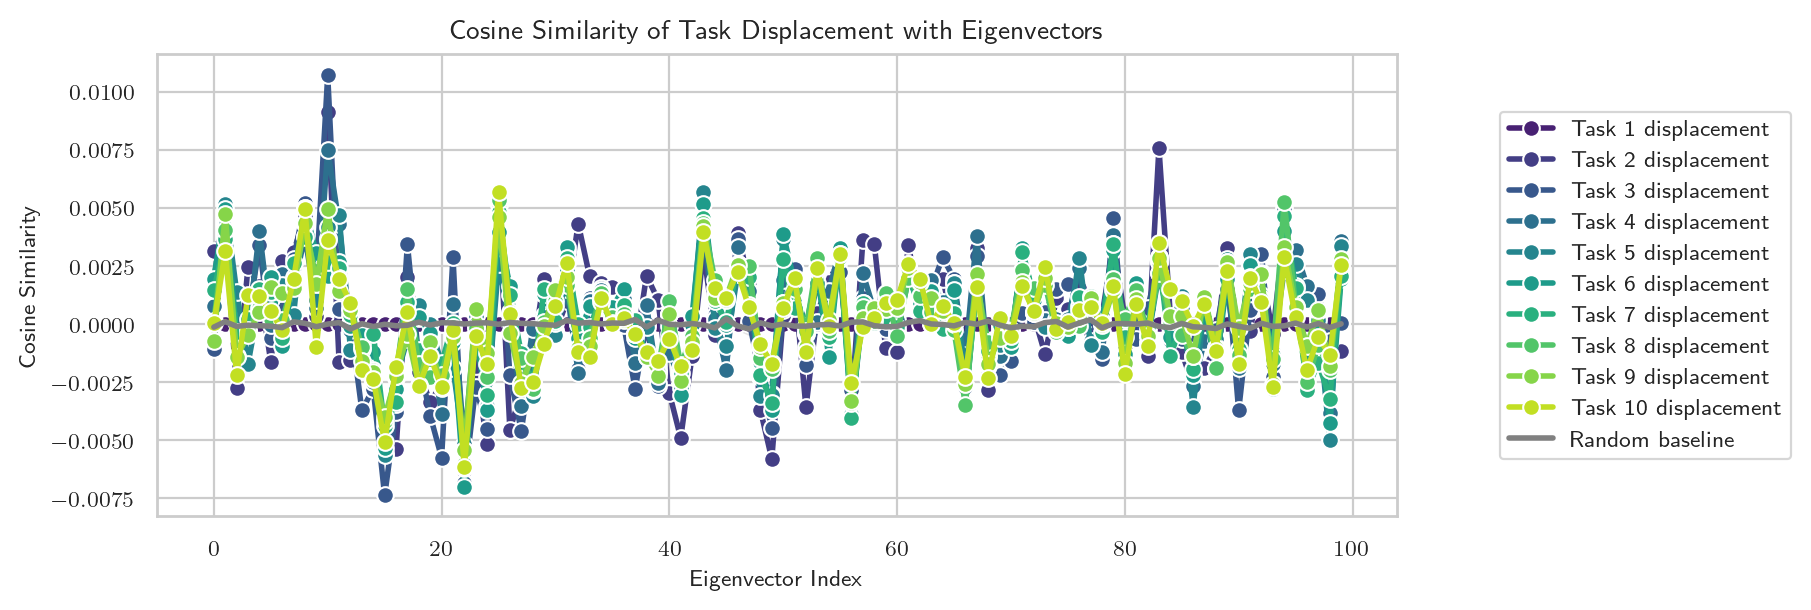

In [118]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=200)
palette = sns.color_palette("viridis", num_tasks)

# Plot each row of the all_alignments matrix
for i in range(num_tasks):
    sns.lineplot(x=range(K), y=all_alignments[i], label=f'Task {i+1} displacement', color=palette[i], marker='o', markersize=6)

sns.lineplot(x=list(range(K)) * num_tasks, y=random_alignments.flatten(), color="gray", label='Random baseline')
# Plot the eigenvalues
#sns.lineplot(x=range(K), y=eigenvalues, label='Eigenvalues', color='black', linestyle='--')

plt.xlabel('Eigenvector Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity of Task Displacement with Eigenvectors')
plt.legend()

plt.legend(loc='upper center', bbox_to_anchor=(1.2, 0.9), ncol=1)
plt.show()

In [119]:
fig.savefig('figures/SpectrumAlignment1000ST.pdf', dpi=200, bbox_inches='tight')